## Customer Churn Prediction

#### Loading Libraries

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras

# Metrics and Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Utilities
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

### Data Preprocessing:

#### 1.1 Load the provided dataset and perform initial data exploration.

In [2]:
# Load data from the local Excel file
file_path = "customer_churn_large_dataset.xlsx" 
df = pd.read_excel(file_path)

# Display first few rows of the dataset
print(df.head())

   CustomerID        Name  Age  Gender     Location  \
0           1  Customer_1   63    Male  Los Angeles   
1           2  Customer_2   62  Female     New York   
2           3  Customer_3   24  Female  Los Angeles   
3           4  Customer_4   36  Female        Miami   
4           5  Customer_5   46  Female        Miami   

   Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  Churn  
0                          17         73.36             236      0  
1                           1         48.76             172      0  
2                           5         85.47             460      0  
3                           3         97.94             297      1  
4                          19         58.14             266      0  


#### 1.2 Handle missing data and outliers.

In [3]:
# Checking for missing values
print(df.isnull().sum())

CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64


In [4]:
# Filling the missing numerical values with median
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    df[column].fillna(df[column].median(), inplace=True)

# Filling the missing categorical values with mode
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna(df[column].mode()[0], inplace=True)


In [5]:
# Checking for outliers (using the IQR method for the 'Monthly_Bill')
Q1 = df['Monthly_Bill'].quantile(0.25)
Q3 = df['Monthly_Bill'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out outliers
df = df[(df['Monthly_Bill'] >= lower_bound) & (df['Monthly_Bill'] <= upper_bound)]


#### 1.3 Prepare the data for machine learning.

In [6]:
# Encoding categorical variables
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Location'] = le.fit_transform(df['Location'])

In [7]:
# Splitting data into training and testing sets
X = df.drop(columns=['CustomerID', 'Name', 'Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 2. Feature Engineering:

#### 2.1 Generate relevant features.

In [8]:
# Createg Usage to Bill Ratio
df['Usage_to_Bill_Ratio'] = df['Total_Usage_GB'] / df['Monthly_Bill']


In [9]:
# Create Age Group
bins = [18, 30, 40, 50, 60, 70, 80]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Convert Age Group to numerical values
df['Age_Group'] = df['Age_Group'].astype(str)
le_age_group = LabelEncoder()
df['Age_Group'] = le_age_group.fit_transform(df['Age_Group'])


#### 2.2 Apply feature scaling.

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#### 2.3 Feature Selection:

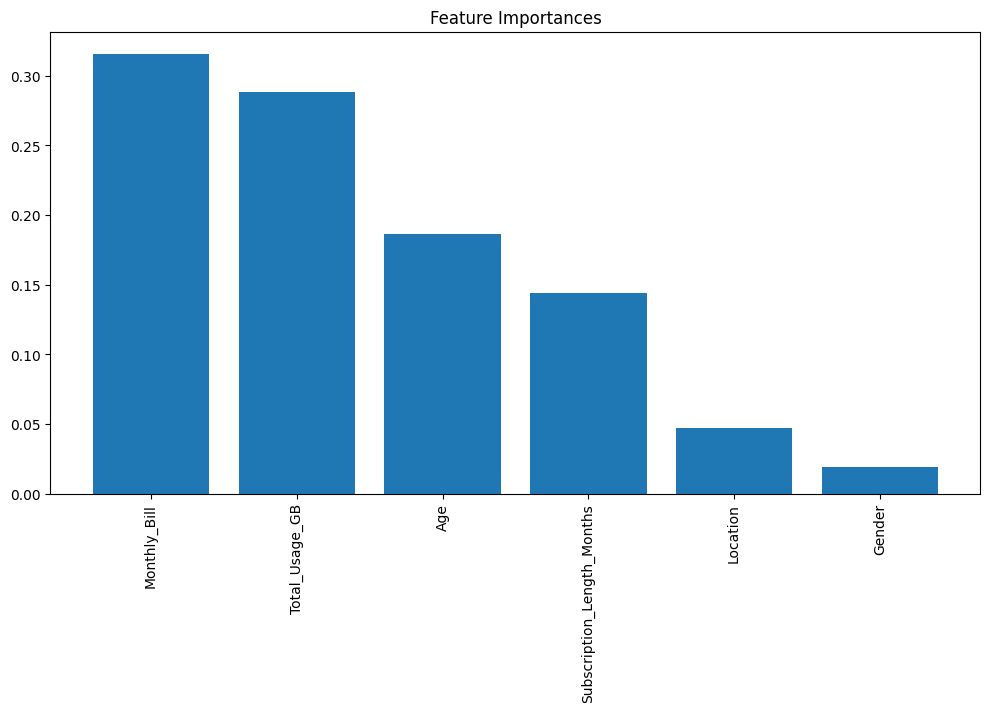

In [11]:
#feature importance
rf_for_importance = RandomForestClassifier()
rf_for_importance.fit(X_train, y_train)
importances = rf_for_importance.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot for feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.show()


In [24]:
print(X.columns[indices])

Index(['Monthly_Bill', 'Total_Usage_GB', 'Age', 'Subscription_Length_Months',
       'Location', 'Gender'],
      dtype='object')


### 3. Model Building:

#### 3.1 Choose appropriate machine learning algorithms.

##### 3.1.1 Logistic Regression

In [12]:
# Model Training
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Model Validating
y_pred_logistic = logistic_model.predict(X_test)

# Performance Evaluation
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Precision:", precision_score(y_test, y_pred_logistic))
print("Recall:", recall_score(y_test, y_pred_logistic))
print("F1-Score:", f1_score(y_test, y_pred_logistic))


Logistic Regression:
Accuracy: 0.50225
Precision: 0.4977596204533474
Recall: 0.38070758996068943
F1-Score: 0.4314352618653264


##### 3.1.2 Random Forest

In [13]:
# Model Training
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Model Validating
y_pred_rf = rf_model.predict(X_test)

# Performance Evaluation
print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))



Random Forest:
Accuracy: 0.49315
Precision: 0.4886673662119622
Recall: 0.4694083257736115
F1-Score: 0.47884427535859336


##### 3.1.3 Neural Network

In [14]:
# Defining model
nn_model = keras.Sequential([
    keras.layers.Dense(12, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compiling the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training
nn_model.fit(X_train, y_train, epochs=5, batch_size=10, validation_data=(X_test, y_test))

# Model Validating
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype("int32")

# Performance Evaluation
print("\nNeural Network:")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))
print("F1-Score:", f1_score(y_test, y_pred_nn))


Epoch 1/5
8000/8000 [==============================] - 61s 7ms/step - loss: 0.6941 - accuracy: 0.4973 - val_loss: 0.6933 - val_accuracy: 0.5035
Epoch 2/5
8000/8000 [==============================] - 58s 7ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6933 - val_accuracy: 0.5031
Epoch 3/5
8000/8000 [==============================] - 40s 5ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6935 - val_accuracy: 0.4939
Epoch 4/5
8000/8000 [==============================] - 42s 5ms/step - loss: 0.6932 - accuracy: 0.5050 - val_loss: 0.6933 - val_accuracy: 0.4958
Epoch 5/5
625/625 [==============================] - 2s 3ms/step

Neural Network:
Accuracy: 0.50395
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


#### 3.2 Model Evaluation.

625/625 [==============================] - 2s 3ms/step


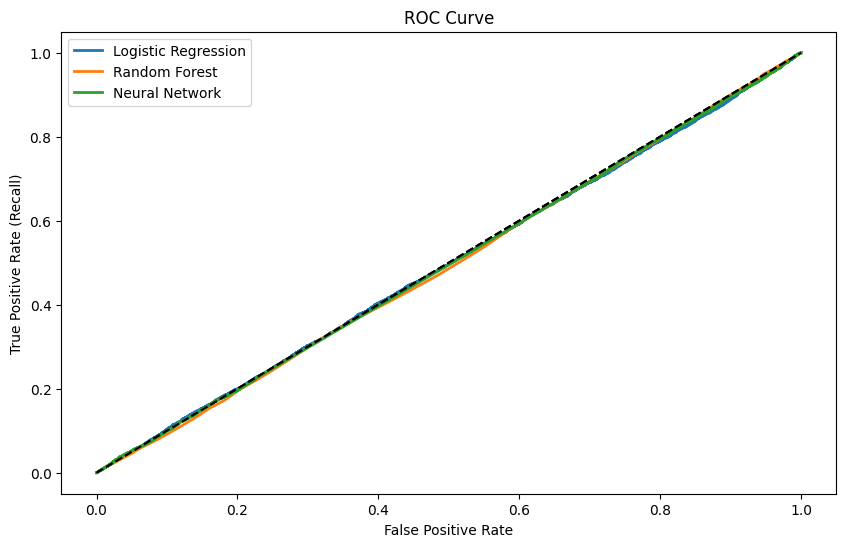

In [15]:
# ROC curve Plotting
def plot_roc_curve(y_true, y_pred_prob, label=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')

# ROC curve for each model
plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, logistic_model.predict_proba(X_test)[:,1], label='Logistic Regression')
plot_roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], label='Random Forest')
plot_roc_curve(y_test, nn_model.predict(X_test).ravel(), label='Neural Network')  # Adjusted for NN
plt.legend()
plt.show()


#### Best model

In [16]:
# Evaluating models and storing results
results = []

# Logistic Regression
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)
avg_logistic = (accuracy_logistic + precision_logistic + recall_logistic + f1_logistic) / 4
results.append(['Logistic Regression', accuracy_logistic, precision_logistic, recall_logistic, f1_logistic, avg_logistic])

# Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
avg_rf = (accuracy_rf + precision_rf + recall_rf + f1_rf) / 4
results.append(['Random Forest', accuracy_rf, precision_rf, recall_rf, f1_rf, avg_rf])

# Neural Network
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
avg_nn = (accuracy_nn + precision_nn + recall_nn + f1_nn) / 4
results.append(['Neural Network', accuracy_nn, precision_nn, recall_nn, f1_nn, avg_nn])

# Convert results to DataFrame 
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Average Score'])
print(results_df)

# Store the best model based on Average Score
best_model_name = results_df.sort_values(by='Average Score', ascending=False).iloc[0]['Model']

if best_model_name == 'Logistic Regression':
    best_model = logistic_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
else:
    best_model = nn_model

print("\nThe best model based on all metrics is:", best_model_name)


                 Model  Accuracy  Precision    Recall  F1-Score  Average Score
0  Logistic Regression   0.50225   0.497760  0.380708  0.431435       0.453038
1        Random Forest   0.49315   0.488667  0.469408  0.478844       0.482517
2       Neural Network   0.50395   0.000000  0.000000  0.000000       0.125988

The best model based on all metrics is: Random Forest


### 4. Model Optimization:

In [17]:
# Check the best model and optimize accordingly
if best_model_name == 'Random Forest':
    # Hyperparameters for Random Forest
    rf_params = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # GridSearchCV for Random Forest
    rf_search = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='f1', verbose=2, n_jobs=-1)
    rf_search.fit(X_train, y_train)

    best_rf_params = rf_search.best_params_
    print("Best parameters for Random Forest:", best_rf_params)

    # Train with best parameters
    optimized_rf = RandomForestClassifier(**best_rf_params)
    optimized_rf.fit(X_train, y_train)

    # Validate and Evaluate with optimized model
    y_pred_optimized_rf = optimized_rf.predict(X_test)
    print("\nOptimized Random Forest:")
    print("Accuracy:", accuracy_score(y_test, y_pred_optimized_rf))
    print("Precision:", precision_score(y_test, y_pred_optimized_rf))
    print("Recall:", recall_score(y_test, y_pred_optimized_rf))
    print("F1-Score:", f1_score(y_test, y_pred_optimized_rf))

elif best_model_name == 'Logistic Regression':
    # Hyperparameters for Logistic Regression
    lr_params = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    # GridSearchCV for Logistic Regression
    lr_search = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, scoring='f1', verbose=2, n_jobs=-1)
    lr_search.fit(X_train, y_train)

    best_lr_params = lr_search.best_params_
    print("Best parameters for Logistic Regression:", best_lr_params)

    # Train with best parameters
    optimized_lr = LogisticRegression(**best_lr_params, max_iter=1000)
    optimized_lr.fit(X_train, y_train)

    # Validate and Evaluate the optimized model
    y_pred_optimized_lr = optimized_lr.predict(X_test)
    print("\nOptimized Logistic Regression:")
    print("Accuracy:", accuracy_score(y_test, y_pred_optimized_lr))
    print("Precision:", precision_score(y_test, y_pred_optimized_lr))
    print("Recall:", recall_score(y_test, y_pred_optimized_lr))
    print("F1-Score:", f1_score(y_test, y_pred_optimized_lr))

elif best_model_name == 'Neural Network':
    # Hyperparameters to tune
    learning_rates = [0.01, 0.1]
    batch_sizes = [32]
    epochs_list = [5]
    layer_configs = [
        [12, 8],
        [16, 8]
    ]
    activations = ['relu', 'tanh']

    best_params = {}
    best_metrics = {
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1_score': 0
    }

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for epochs in epochs_list:
                for layers in layer_configs:
                    for activation in activations:
                        
                        # Building model based on current hyperparameters
                        nn_model = keras.Sequential()
                        for units in layers:
                            nn_model.add(keras.layers.Dense(units, activation=activation))
                        nn_model.add(keras.layers.Dense(1, activation='sigmoid'))

                        optimizer = keras.optimizers.Adam(learning_rate=lr)
                        nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
                        nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
                        
                        # Predict and compute metrics
                        y_pred_nn = (nn_model.predict(X_test) > 0.5).astype("int32")
                        accuracy = accuracy_score(y_test, y_pred_nn)
                        precision = precision_score(y_test, y_pred_nn)
                        recall = recall_score(y_test, y_pred_nn)
                        f1 = f1_score(y_test, y_pred_nn)

                        # Update best hyperparameters if current model is better
                        if (accuracy + precision + recall + f1) > (best_metrics['accuracy'] + best_metrics['precision'] + best_metrics['recall'] + best_metrics['f1_score']):
                            best_metrics = {
                                'accuracy': accuracy,
                                'precision': precision,
                                'recall': recall,
                                'f1_score': f1
                            }
                            best_params = {
                                'learning_rate': lr,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'layer_config': layers,
                                'activation': activation
                            }

    print("\nBest hyperparameters for Neural Network:")
    print("---------------------------------------")
    print(f"{best_params}\n")
    print("With metrics:")
    print("-------------")
    print(f"{best_metrics}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}

Optimized Random Forest:
Accuracy: 0.4956
Precision: 0.4914891448374274
Recall: 0.48603971373853444
F1-Score: 0.48874923981350094


#### Comparison

In [18]:
# Determine best model
if best_model_name == 'Logistic Regression':
    y_pred_prev = y_pred_logistic
elif best_model_name == 'Random Forest':
    y_pred_prev = y_pred_rf
else:  # Neural Network
    y_pred_prev = y_pred_nn

if best_model_name == 'Random Forest':
    y_pred_optimized = y_pred_optimized_rf
elif best_model_name == 'Neural Network':
    y_pred_optimized = y_pred_nn  
else:
    y_pred_optimized = y_pred_logistic  

# Compute metrics for the previous (non-optimized) model
accuracy_prev = accuracy_score(y_test, y_pred_prev)
precision_prev = precision_score(y_test, y_pred_prev)
recall_prev = recall_score(y_test, y_pred_prev)
f1_prev = f1_score(y_test, y_pred_prev)

# Compute metrics for the new (optimized) model
accuracy_opt = accuracy_score(y_test, y_pred_optimized)
precision_opt = precision_score(y_test, y_pred_optimized)
recall_opt = recall_score(y_test, y_pred_optimized)
f1_opt = f1_score(y_test, y_pred_optimized)

# Calculate the differences
accuracy_diff = accuracy_opt - accuracy_prev
precision_diff = precision_opt - precision_prev
recall_diff = recall_opt - recall_prev
f1_diff = f1_opt - f1_prev

print("\nComparison between Previous and Optimized Model:")
print("-----------------------------------------------")
print(f"Difference in Accuracy: {accuracy_diff:.4f}")
print(f"Difference in Precision: {precision_diff:.4f}")
print(f"Difference in Recall: {recall_diff:.4f}")
print(f"Difference in F1-Score: {f1_diff:.4f}")


Comparison between Previous and Optimized Model:
-----------------------------------------------
Difference in Accuracy: 0.0025
Difference in Precision: 0.0028
Difference in Recall: 0.0166
Difference in F1-Score: 0.0099


#### Model Deployment

In [19]:
print(optimized_rf)

RandomForestClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=50)


In [22]:
# Save the trained model
joblib.dump(best_model, 'optimized_rf.pkl') 
joblib.dump(scaler, 'scaler.pkl') 
joblib.dump(le, 'gender_encoder.pkl')

['gender_encoder.pkl']

In [23]:
# Encoding 'Location'
le_location = LabelEncoder()
df['Location'] = le_location.fit_transform(df['Location'])
joblib.dump(le_location, 'location_encoder.pkl')

['location_encoder.pkl']